In [2]:
!pip install opendatasets

In [26]:
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [4]:
dataset_path = Path('historical-hourly-weather-data', 'temperature.csv')

if not dataset_path.is_file():
    od.download('https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data?select=temperature.csv')

df = pd.read_csv(dataset_path)
df.head()
df.shape

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xcution28
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data


100%|██████████| 12.0M/12.0M [00:00<00:00, 63.2MB/s]


(45253, 37)

In [5]:
# вывожу список городов
print(df.columns)

Index(['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa',
       'Nahariyya', 'Jerusalem'],
      dtype='object')


In [6]:
# выбираю Альбукерке
df = df[['datetime', 'Albuquerque']]

In [7]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     45253 non-null  object 
 1   Albuquerque  45252 non-null  float64
dtypes: float64(1), object(1)
memory usage: 707.2+ KB


In [12]:
# проверяю на наличие пропущенных значений
df.isna().sum()

,0
datetime,0
Albuquerque,0


In [13]:
df = df.dropna()

In [14]:
data = df['Albuquerque'].values # преобразую в массив
scaler = MinMaxScaler(feature_range=(0, 1)) # масштабирую данные в диапазоне от 0 до 1
data = data.reshape(-1, 1) # делаю двумерный массив, где каждый элемент является отдельной строкой
data = scaler.fit_transform(data).flatten() # масштабирую данные и снова преобразую в одномерный массив

In [15]:
data

array([0.52156899, 0.52216825, 0.523545  , ..., 0.54445877, 0.53925654,
       0.51428588])

In [16]:
def get_XY(data, window):
 Y_index = np.arange(window, len(data), window) # создаю индексы для целевых значений, начиная с размера окна и увеличивая на размер окна
 Y = data[Y_index] # извлекаю целевые значения из данных по созданным индексам
 rows_x = len(Y) # вычисляю количество строк в массиве X
 X = data[range(window*rows_x)] # создаю индексы для входных данных, начиная с 0 и заканчивая последним индексом целевого значения
 X = np.reshape(X, (rows_x, window, 1)) # изменяю форму массива X, чтобы он соответствовал ожидаемому формату для модели (samples, time steps, features)
 return X, Y

window = 20 # устанавливаю размер окна
X, y = get_XY(data, window) # получаю входные данные (X) и целевые значения (Y)

In [19]:
# разделяю данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [27]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units,
    input_shape=input_shape,
    activation=activation[0],
    return_sequences=False))
    model.add(Dense(units=dense_units,
    activation=activation[1]))
    model.compile(loss='mean_squared_error',
    optimizer='adam',
    metrics=['mean_absolute_error',
    'mean_squared_error'])
    model.summary()
    return model

def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, activation=activation[0], return_sequences=False))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'mean_squared_error'])
    model.summary()
    return model

def create_GRU(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(GRU(hidden_units, input_shape=input_shape, activation=activation[0], return_sequences=False))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'mean_squared_error'])
    model.summary()
    return model

def create_stacked_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, activation=activation[0], return_sequences=True))
    model.add(LSTM(hidden_units, activation=activation[0], return_sequences=False))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'mean_squared_error'])
    model.summary()
    return model

def create_stacked_GRU(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(GRU(hidden_units, input_shape=input_shape, activation=activation[0], return_sequences=True))
    model.add(GRU(hidden_units, activation=activation[0], return_sequences=False))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'mean_squared_error'])
    model.summary()
    return model


In [28]:
# создаю словарь моделей
models = {
    'RNN': create_RNN(hidden_units=32, dense_units=1, input_shape=(window, 1), activation=['relu', 'linear']),
    'LSTM': create_LSTM(hidden_units=32, dense_units=1, input_shape=(window, 1), activation=['tanh', 'linear']),
    'GRU': create_GRU(hidden_units=32, dense_units=1, input_shape=(window, 1), activation=['tanh', 'linear']),
    'Stacked LSTM': create_stacked_LSTM(hidden_units=32, dense_units=1, input_shape=(window, 1), activation=['tanh', 'linear']),
    'Stacked GRU': create_stacked_GRU(hidden_units=32, dense_units=1, input_shape=(window, 1), activation=['tanh', 'linear'])
}

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 32)                  │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 20, 32)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# обучаю модели и сохраняем историю обучения
histories = {}
for name, model in models.items():
    print(f"Training {name} model...")
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_split=0.2)
    histories[name] = history

Training RNN model...
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1449 - mean_absolute_error: 0.3157 - mean_squared_error: 0.1449 - val_loss: 0.0079 - val_mean_absolute_error: 0.0759 - val_mean_squared_error: 0.0079
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - mean_absolute_error: 0.0699 - mean_squared_error: 0.0067 - val_loss: 0.0035 - val_mean_absolute_error: 0.0505 - val_mean_squared_error: 0.0035
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0469 - mean_squared_error: 0.0033 - val_loss: 0.0021 - val_mean_absolute_error: 0.0379 - val_mean_squared_error: 0.0021
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0358 - mean_squared_error: 0.0021 - val_loss: 0.0017 - val_mean_absolute_error: 0.0322 - val_mean_squared_error: 0.0017
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mean_absolute_error: 0.0332 - mean_squared_error: 0.0019 - val_loss: 0

Построение графика обучения и валидации потерь для модели RNN...


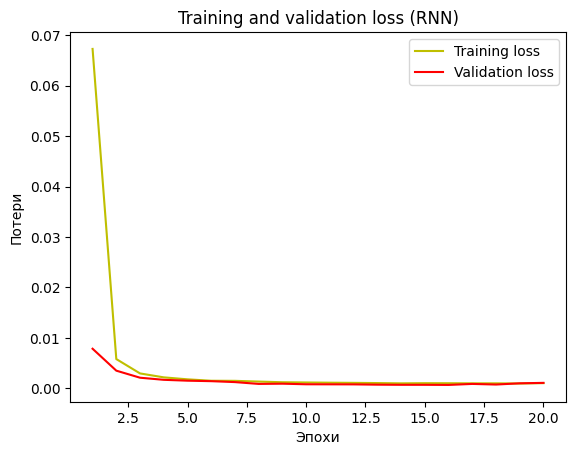

Построение графика обучения и валидации потерь для модели LSTM...


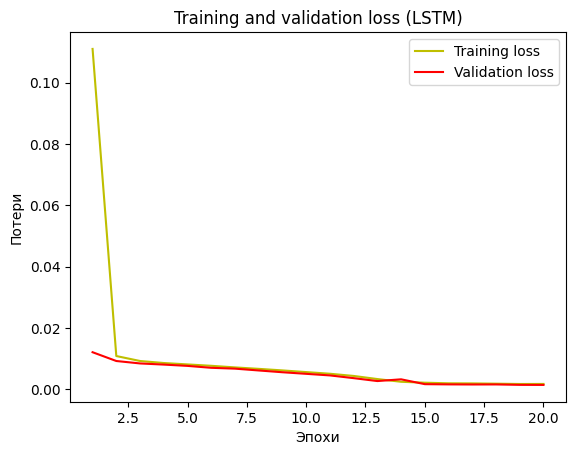

Построение графика обучения и валидации потерь для модели GRU...


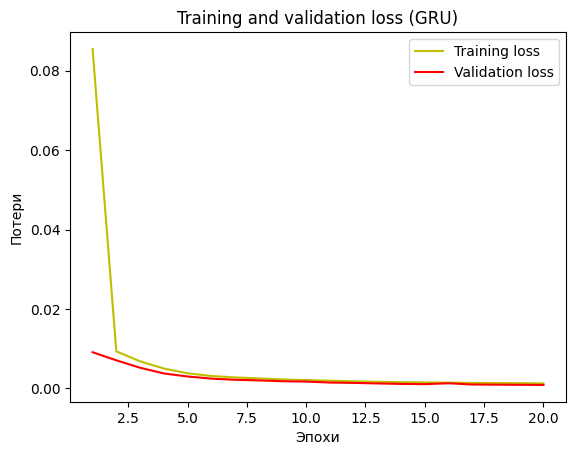

Построение графика обучения и валидации потерь для модели Stacked LSTM...


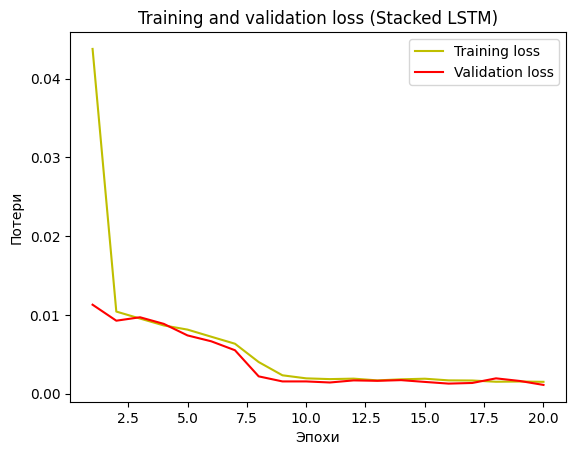

Построение графика обучения и валидации потерь для модели Stacked GRU...


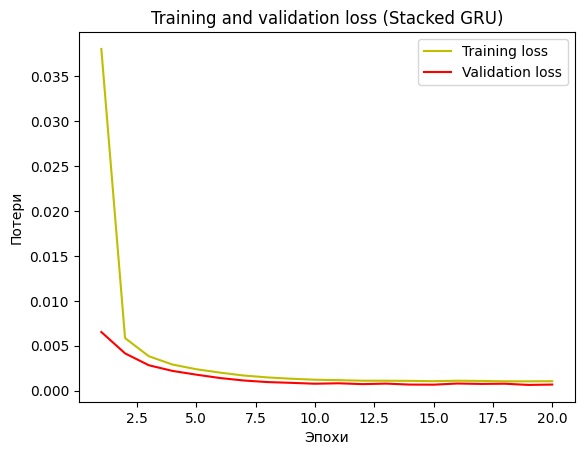

In [34]:
def plot_training_validation_loss(history, model_name):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss ({model_name})')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()
    plt.show()

for name, history in histories.items():
    print(f"Построение графика обучения и валидации потерь для модели {name}...")
    plot_training_validation_loss(history, name)

In [31]:
def print_error(trainY, testY, train_predict, test_predict):
    mae_train = mean_absolute_error(trainY, train_predict)
    mse_train = mean_squared_error(trainY, train_predict)
    print(f'train MAE: {mae_train:.10f}')
    print(f'train MSE: {mse_train:.10f}')

    mae_test = mean_absolute_error(testY, test_predict)
    mse_test = mean_squared_error(testY, test_predict)
    print(f'test MAE: {mae_test:.10f}')
    print(f'test MSE: {mse_test:.10f}')

In [35]:
def plot_result(testY, test_predict, model_name):
    actual = testY
    predictions = test_predict
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=100)
    plt.plot(range(rows), actual, linewidth=0.9)
    plt.plot(range(rows), predictions, linewidth=0.7)
    plt.legend(['Реальная температура', 'Предсказание'])
    plt.xlabel('Номер наблюдения')
    plt.ylabel('Отмасштабированная температура')
    plt.title(f'Реальная и предсказанная температура ({model_name})')
    plt.show()

Оценка модели RNN
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
train MAE: 0.0289351874
train MSE: 0.0013847620
test MAE: 0.0292834129
test MSE: 0.0014823786


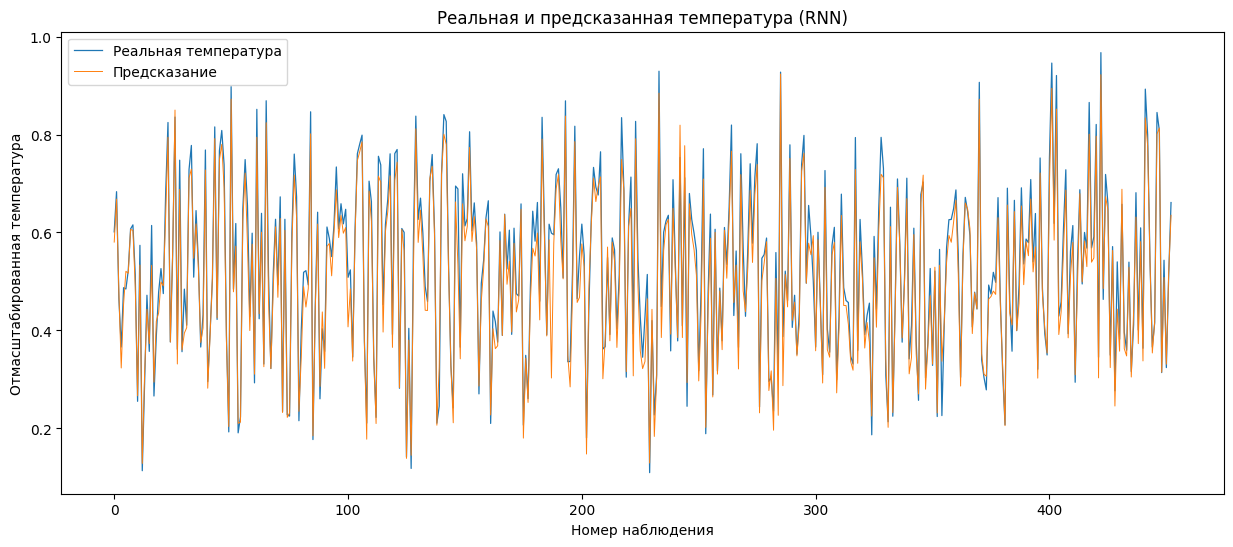

Оценка модели LSTM
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
train MAE: 0.0317154555
train MSE: 0.0016569271
test MAE: 0.0327033528
test MSE: 0.0019189042


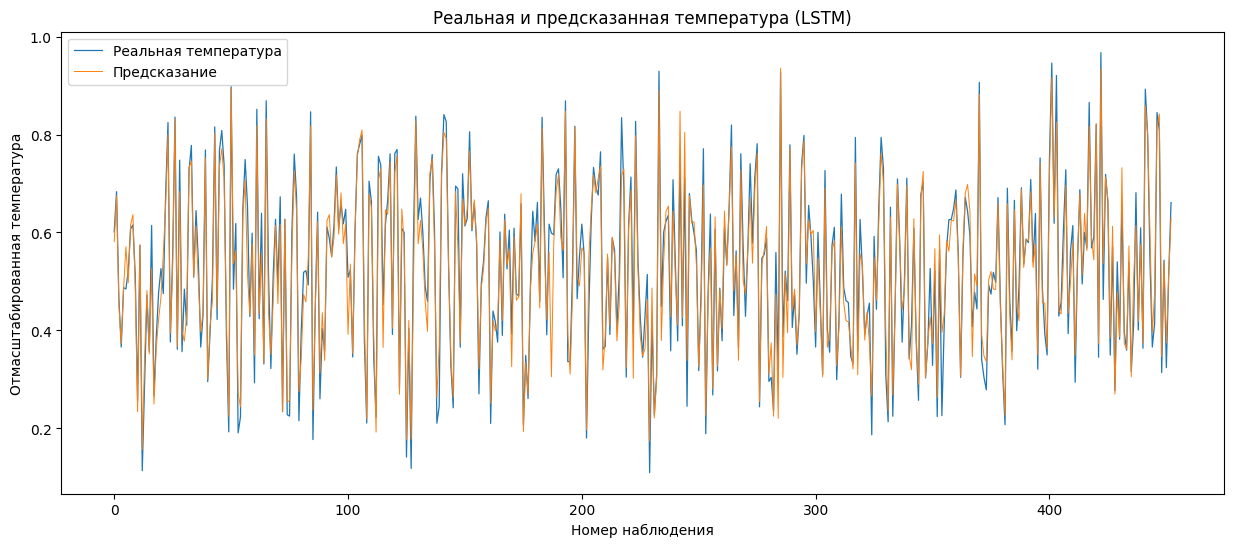

Оценка модели GRU
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
train MAE: 0.0238476682
train MSE: 0.0011454540
test MAE: 0.0246135799
test MSE: 0.0012686660


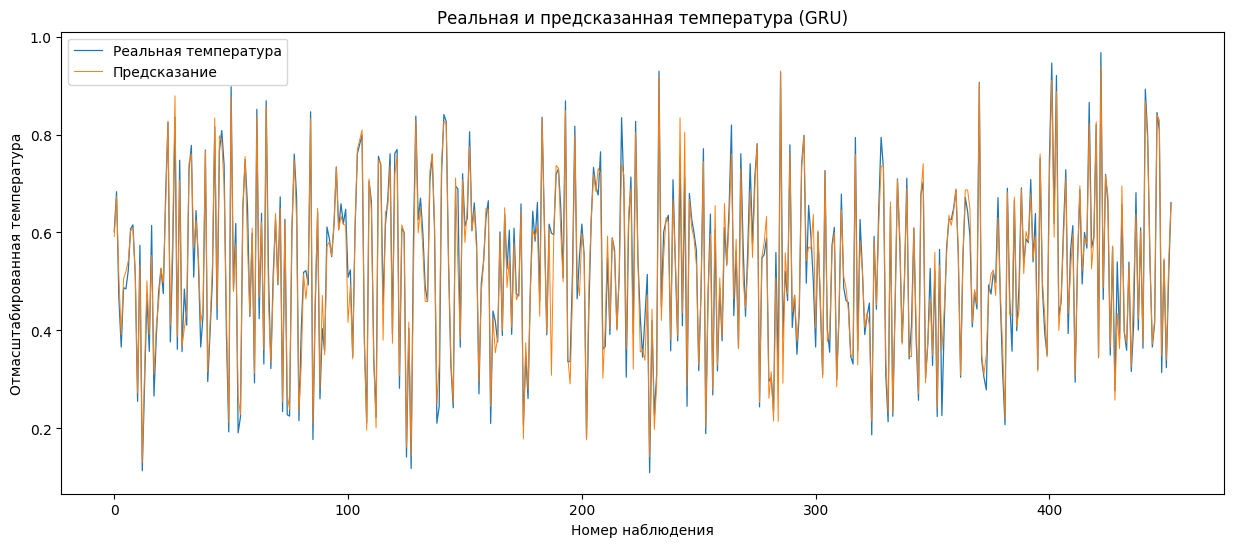

Оценка модели Stacked LSTM
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
train MAE: 0.0264248443
train MSE: 0.0012814383
test MAE: 0.0273459175
test MSE: 0.0015006998


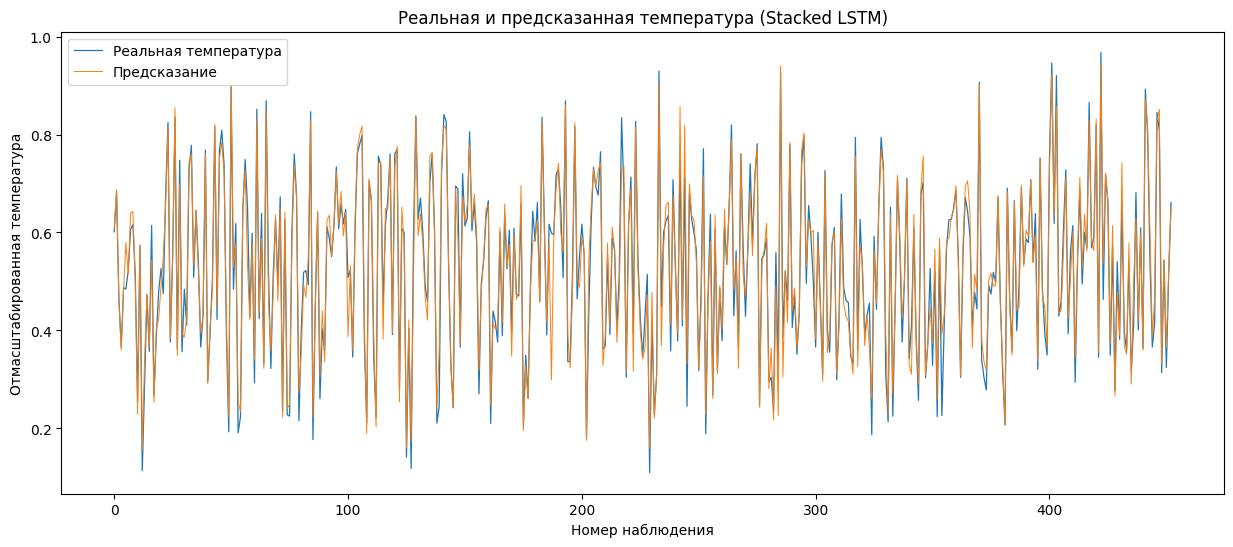

Оценка модели Stacked GRU
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
train MAE: 0.0207825524
train MSE: 0.0009502551
test MAE: 0.0208009275
test MSE: 0.0009405659


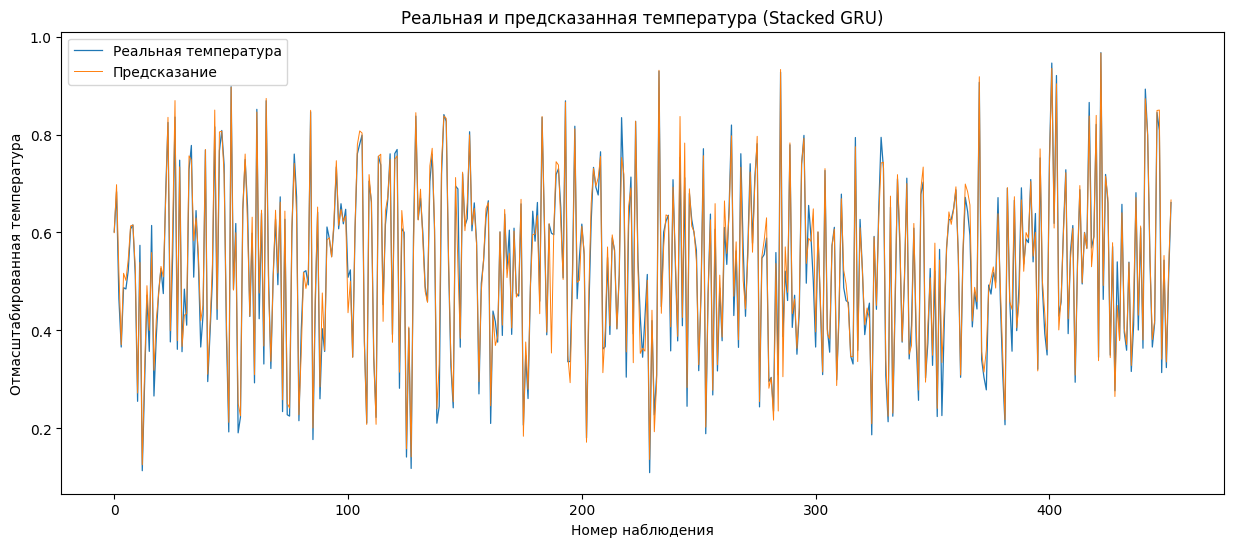

In [36]:
for name, model in models.items():
    print(f"Оценка модели {name}")
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    print_error(y_train, y_test, train_predict, test_predict)
    plot_result(y_test, test_predict, name)